In [65]:
%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [116]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.decomposition import PCA
from scipy import stats
from scipy.stats.mstats import winsorize
import warnings
import plotly_express as px

warnings.filterwarnings("ignore")

<IPython.core.display.Javascript object>

##### Connect to database and create `life_data` dataframe

In [117]:
postgres_user = "dsbc_student"
postgres_pw = "7*.8G9QH21"
postgres_host = "142.93.121.174"
postgres_port = "5432"
postgres_db = "lifeexpectancy"
table_name = "lifeexpectancy"

engine = create_engine(
    "postgresql://{}:{}@{}:{}/{}".format(
        postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db
    )
)

life = pd.read_sql_query("select * from lifeexpectancy", con=engine)
life_data = pd.read_sql_query("select * from lifeexpectancy", con=engine)
engine.dispose()

<IPython.core.display.Javascript object>

In [118]:
# Format column headers
life_data.columns = [i.lower().strip() for i in life_data.columns]
life_data.columns

Index(['country', 'year', 'status', 'life expectancy', 'adult mortality',
       'infant deaths', 'alcohol', 'percentage expenditure', 'hepatitis b',
       'measles', 'bmi', 'under-five deaths', 'polio', 'total expenditure',
       'diphtheria', 'hiv/aids', 'gdp', 'population', 'thinness  1-19 years',
       'thinness 5-9 years', 'income composition of resources', 'schooling'],
      dtype='object')

<IPython.core.display.Javascript object>

##### Inspect data for missing values, outliers, and inaccurate values

In [119]:
life_data.head()

,country,year,status,life expectancy,adult mortality,infant deaths,alcohol,percentage expenditure,hepatitis b,measles,...,polio,total expenditure,diphtheria,hiv/aids,gdp,population,thinness 1-19 years,thinness 5-9 years,income composition of resources,schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


<IPython.core.display.Javascript object>

In [120]:
# Check for percentage of null values in each column
life_nulls = life_data.isnull().mean().sort_values(ascending=True)
life_nulls

country                            0.000000
year                               0.000000
status                             0.000000
infant deaths                      0.000000
percentage expenditure             0.000000
measles                            0.000000
hiv/aids                           0.000000
under-five deaths                  0.000000
life expectancy                    0.003404
adult mortality                    0.003404
polio                              0.006467
diphtheria                         0.006467
thinness 5-9 years                 0.011572
thinness  1-19 years               0.011572
bmi                                0.011572
schooling                          0.055480
income composition of resources    0.056841
alcohol                            0.066031
total expenditure                  0.076923
gdp                                0.152485
hepatitis b                        0.188223
population                         0.221920
dtype: float64

<IPython.core.display.Javascript object>

There appears to be some values that do not make sense such as the change in Afghanistan's population from 2014 to 2015, or the GDP of Afghanistan in 2011 compared to other years.

There are quite a few rows with missing values, around 20% of rows are missing data about population and hepatitis B. We will interpolate data by country to fill in null values

In [121]:
# Interpolate data for each country from data from surrounding years for each country.
life_nulls = life_data.isnull().mean().sort_values(ascending=True)
bad_cols = [i for i, v in life_nulls.iteritems() if v != 0]
countries = life_data["country"].unique()

for country in countries:
    life_data.loc[life_data["country"] == country, bad_cols] = life_data.loc[
        life_data["country"] == country, bad_cols
    ].interpolate(limit_direction="both")

<IPython.core.display.Javascript object>

In [122]:
# Check for percentage of null values in each column
life_nulls = life_data.isnull().mean().sort_values(ascending=True)
life_nulls

country                            0.000000
year                               0.000000
status                             0.000000
infant deaths                      0.000000
percentage expenditure             0.000000
measles                            0.000000
under-five deaths                  0.000000
polio                              0.000000
diphtheria                         0.000000
hiv/aids                           0.000000
life expectancy                    0.003404
adult mortality                    0.003404
alcohol                            0.005786
total expenditure                  0.010892
thinness 5-9 years                 0.011572
thinness  1-19 years               0.011572
bmi                                0.011572
hepatitis b                        0.049013
schooling                          0.055480
income composition of resources    0.056841
gdp                                0.137849
population                         0.220558
dtype: float64

<IPython.core.display.Javascript object>

Interpolation seems to work for most data points. There are still a lot of nulls for population and gdp. Interpolation did not work for some columns because there are countries missing those values in every year of data, such as the Bahamas.

In [123]:
life_data.loc[life_data["country"] == "Bahamas"]

,country,year,status,life expectancy,adult mortality,infant deaths,alcohol,percentage expenditure,hepatitis b,measles,...,polio,total expenditure,diphtheria,hiv/aids,gdp,population,thinness 1-19 years,thinness 5-9 years,income composition of resources,schooling
161,Bahamas,2015,Developing,76.1,147.0,0,9.45,0.0,95.0,0,...,95.0,7.74,95.0,0.1,NaN,NaN,2.5,2.5,0.790,12.6
162,Bahamas,2014,Developing,75.4,16.0,0,9.45,0.0,96.0,0,...,96.0,7.74,96.0,0.1,NaN,NaN,2.5,2.5,0.789,12.6
163,Bahamas,2013,Developing,74.8,172.0,0,9.42,0.0,97.0,0,...,97.0,7.50,97.0,0.1,NaN,NaN,2.5,2.5,0.790,12.6
164,Bahamas,2012,Developing,74.9,167.0,0,9.50,0.0,96.0,0,...,99.0,7.43,98.0,0.2,NaN,NaN,2.5,2.5,0.789,12.6
165,Bahamas,2011,Developing,75.0,162.0,0,9.34,0.0,95.0,0,...,97.0,7.63,98.0,0.1,NaN,NaN,2.5,2.5,0.788,12.6
166,Bahamas,2010,Developing,75.0,161.0,0,9.19,0.0,98.0,0,...,97.0,7.44,99.0,0.2,NaN,NaN,2.5,2.5,0.788,12.6
167,Bahamas,2009,Developing,74.6,168.0,0,9.29,0.0,95.0,0,...,97.0,7.43,96.0,0.1,NaN,NaN,2.5,2.5,0.791,12.6
168,Bahamas,2008,Developing,74.5,167.0,0,10.15,0.0,9.0,0,...,93.0,7.30,93.0,0.1,NaN,NaN,2.5,2.5,0.791,12.6
169,Bahamas,2007,Developing,74.4,167.0,0,10.75,0.0,93.0,0,...,95.0,7.80,95.0,0.1,NaN,NaN,2.5,2.5,0.790,12.5
170,Bahamas,2006,Developing,74.2,171.0,0,11.07,0.0,96.0,0,...,94.0,6.93,95.0,0.1,NaN,NaN,2.5,2.5,0.788,12.4


<IPython.core.display.Javascript object>

Having already created a correlation matrix for this dataset we already know that population and GDP are not correlated to life expectancy so we will drop gdp and population columns. Correlation could have been affected by missing values but if we drop the rows with null values, that would be over 20% of the data which is a lot.

In [124]:
life_data_dropped = life_data.drop(columns=["population", "gdp"])

<IPython.core.display.Javascript object>

In [125]:
life_nulls = life_data_dropped.isnull().mean().sort_values(ascending=True)
life_nulls

country                            0.000000
hiv/aids                           0.000000
diphtheria                         0.000000
polio                              0.000000
under-five deaths                  0.000000
percentage expenditure             0.000000
measles                            0.000000
infant deaths                      0.000000
status                             0.000000
year                               0.000000
adult mortality                    0.003404
life expectancy                    0.003404
alcohol                            0.005786
total expenditure                  0.010892
bmi                                0.011572
thinness  1-19 years               0.011572
thinness 5-9 years                 0.011572
hepatitis b                        0.049013
schooling                          0.055480
income composition of resources    0.056841
dtype: float64

<IPython.core.display.Javascript object>

There are stil some rows with null values but not quite as many, so we will drop rows with missing values. Imputing with median/mean would not work because we would be using innacurate data from other countries. Dropping nulls drops around 10% data, still plenty of data to work with.

In [129]:
life_data_dropped.dropna(inplace=True)
life_data_dropped.shape

(2608, 20)

<IPython.core.display.Javascript object>

In [130]:
# Create cols list of columns to test outliers
cols = list(life_data_dropped)
for elem in cols:
    if elem in ["country", "year", "status"]:
        cols.remove(elem)
cols.remove("year")
cols

['life expectancy',
 'adult mortality',
 'infant deaths',
 'alcohol',
 'percentage expenditure',
 'hepatitis b',
 'measles',
 'bmi',
 'under-five deaths',
 'polio',
 'total expenditure',
 'diphtheria',
 'hiv/aids',
 'thinness  1-19 years',
 'thinness 5-9 years',
 'income composition of resources',
 'schooling']

<IPython.core.display.Javascript object>

In [131]:
# Tukey's method to test for outliers
for elem in cols:
    q75, q25 = np.percentile(life_data_dropped[elem], [75, 25])
    iqr = q75 - q25
    min_val = q25 - (iqr * 1.5)
    max_val = q75 + (iqr * 1.5)
    print(elem)
    print(
        "Outliers:",
        len(
            (
                np.where(
                    (life_data_dropped[elem] > max_val)
                    | (life_data_dropped[elem] < min_val)
                )[0]
            )
        ),
        "\n",
    )

life expectancy
Outliers: 34 

adult mortality
Outliers: 80 

infant deaths
Outliers: 295 

alcohol
Outliers: 3 

percentage expenditure
Outliers: 328 

hepatitis b
Outliers: 266 

measles
Outliers: 478 

bmi
Outliers: 0 

under-five deaths
Outliers: 350 

polio
Outliers: 232 

total expenditure
Outliers: 36 

diphtheria
Outliers: 263 

hiv/aids
Outliers: 488 

thinness  1-19 years
Outliers: 80 

thinness 5-9 years
Outliers: 93 

income composition of resources
Outliers: 119 

schooling
Outliers: 56 



<IPython.core.display.Javascript object>

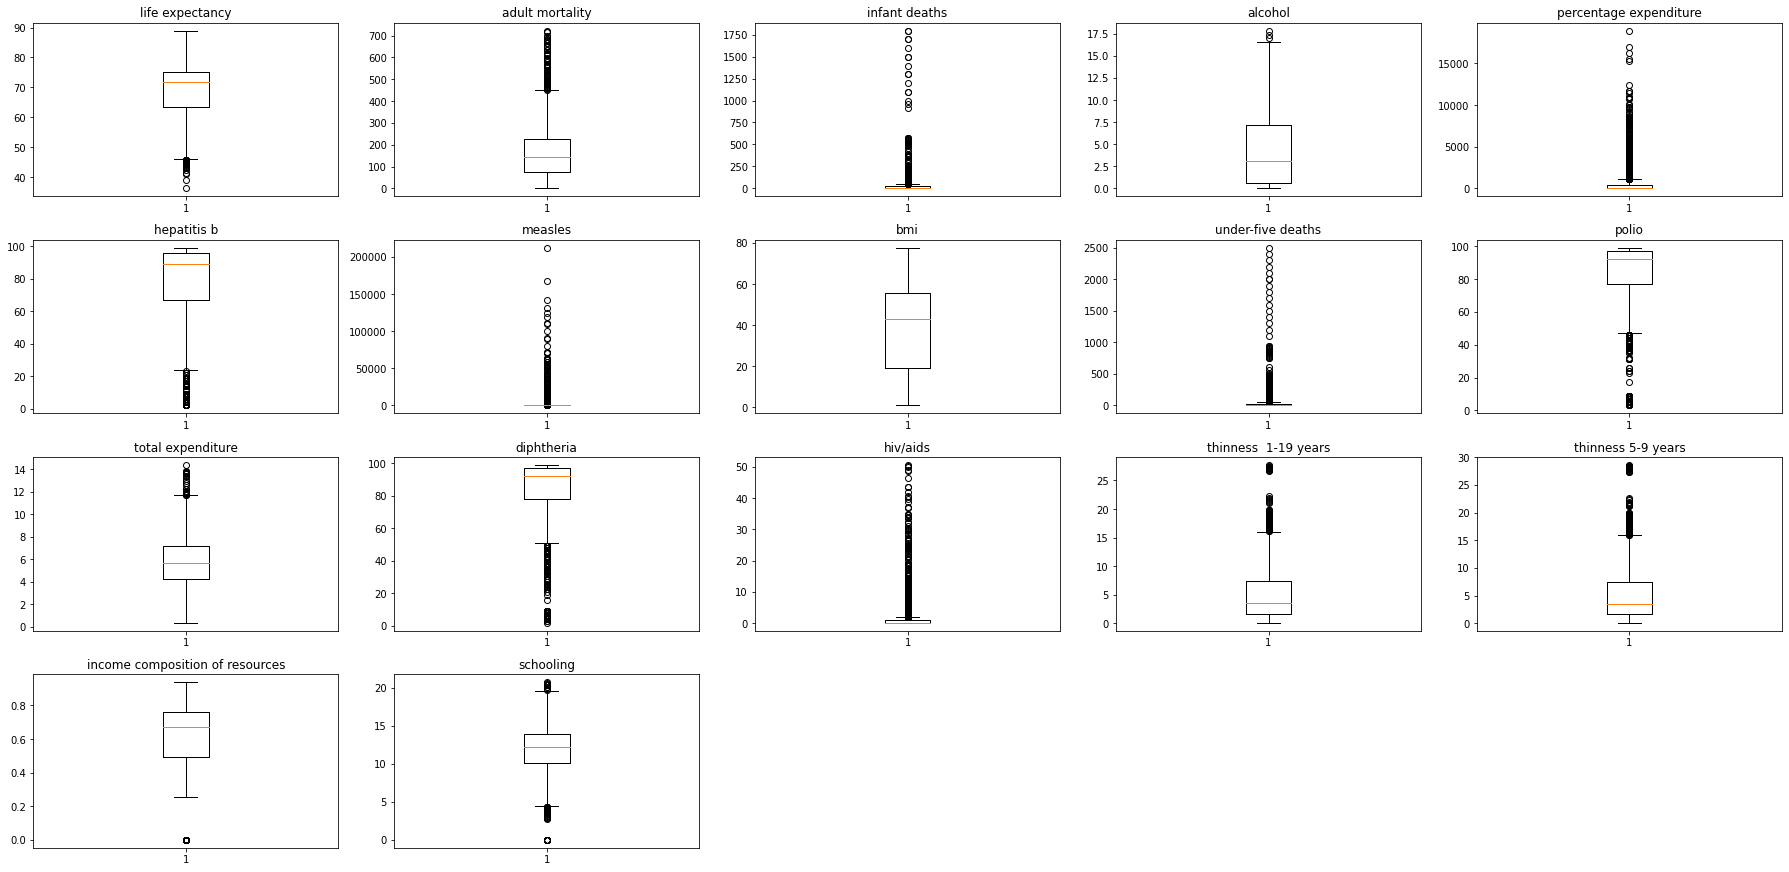

<IPython.core.display.Javascript object>

In [132]:
# Visualize outliers
count = 1
plt.figure(figsize=(25, 15))
for elem in cols:
    plt.subplot(len(cols) / 3, len(cols) / 3, count)
    plt.boxplot(life_data_dropped[elem])
    plt.title(elem)
    count += 1

plt.tight_layout()
plt.show()

Using the boxplots, we can decide which type of windsorization to perform on the columns.

In [133]:
lower_windsorize = ["life expectancy", "polio", "hepatits b", "diphtheria"]
upper_windsorize = [
    "adult mortality",
    "infant deaths",
    "alcohol",
    "percentage expenditure",
    "measles",
    "under-five deaths",
    "total expenditure",
    "hiv/aids",
    "thinness 1-19 years",
    "thinness 5-9 years",
]
two_way_windsorize = ["schooling"]

<IPython.core.display.Javascript object>

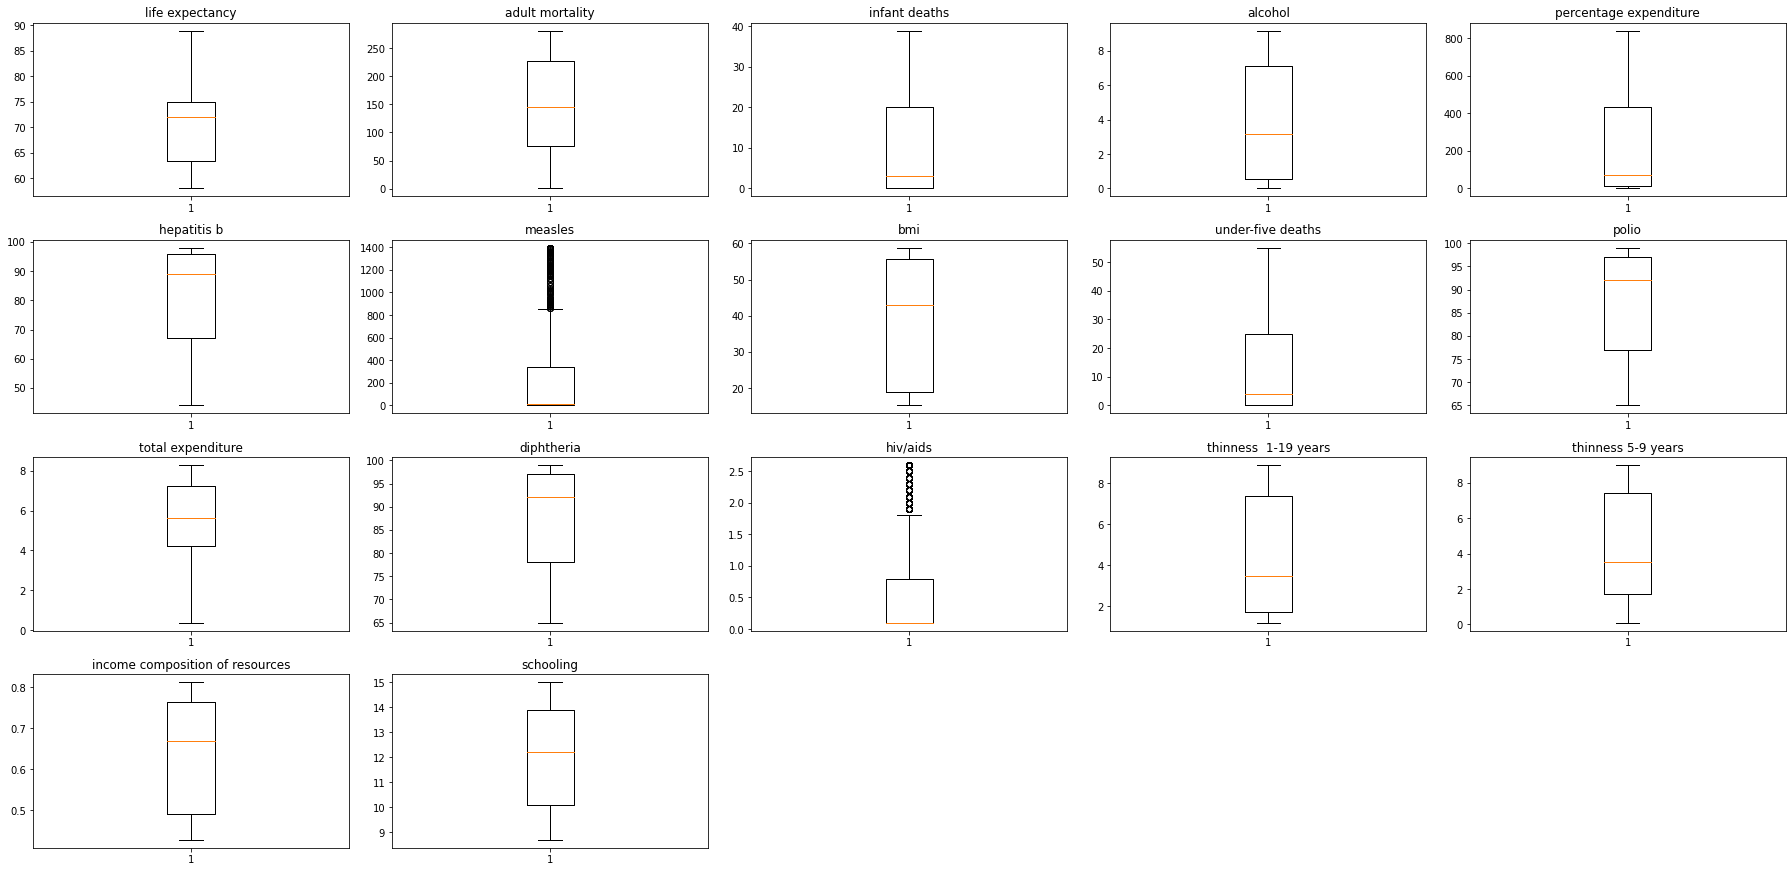

<IPython.core.display.Javascript object>

In [134]:
# Winsorize the data in each column and visualize the outliers
# Remove outliers without affecting the integrity of the data and the accuracy of real lifeness

for elem in cols:
    if elem in lower_windsorize:
        winsorized_life_data[elem] = winsorize(life_data_dropped[elem], (0.15, 0))
    elif elem in upper_windsorize:
        winsorized_life_data[elem] = winsorize(life_data_dropped[elem], (0, 0.15))
    else:
        winsorized_life_data[elem] = winsorize(life_data_dropped[elem], (0.15, 0.15))

count = 1
plt.figure(figsize=(25, 15))
for elem in cols:
    plt.subplot(len(cols) / 3, len(cols) / 3, count)
    plt.boxplot(winsorized_life_data[elem])
    plt.title(elem)
    count += 1

plt.tight_layout()
plt.show()

In [135]:
# Tukey's method to test for outliers in the winsorized data
for elem in cols:
    q75, q25 = np.percentile(winsorized_life_data[elem], [75, 25])
    iqr = q75 - q25
    min_val = q25 - (iqr * 1.5)
    max_val = q75 + (iqr * 1.5)
    print(elem)
    print(
        "Outliers:",
        len(
            (
                np.where(
                    (winsorized_life_data[elem] > max_val)
                    | (winsorized_life_data[elem] < min_val)
                )[0]
            )
        ),
        "\n",
    )

life expectancy
Outliers: 0 

adult mortality
Outliers: 0 

infant deaths
Outliers: 0 

alcohol
Outliers: 0 

percentage expenditure
Outliers: 0 

hepatitis b
Outliers: 0 

measles
Outliers: 478 

bmi
Outliers: 0 

under-five deaths
Outliers: 0 

polio
Outliers: 0 

total expenditure
Outliers: 0 

diphtheria
Outliers: 0 

hiv/aids
Outliers: 488 

thinness  1-19 years
Outliers: 0 

thinness 5-9 years
Outliers: 0 

income composition of resources
Outliers: 0 

schooling
Outliers: 0 



<IPython.core.display.Javascript object>

In [138]:
life_data = winsorized_life_data

<IPython.core.display.Javascript object>

In [139]:
# Convert 'Developing' to 1 and 'Developed' to 0 in the 'Status' column
life_data["status"] = (life_data["status"] == "Developing").astype(int)

<IPython.core.display.Javascript object>

In [146]:
# sklearn SelectKBest function to select the top 5 features using mutual_info_regression
X = life_data.drop(columns=["country", "year", "life expectancy"])
y = life_data["life expectancy"]

selector = SelectKBest(mutual_info_regression, k=5)

k_best = selector.fit_transform(X, y)
score_df = pd.DataFrame({"feature": X.columns, "f_score": selector.scores_})
score_df = score_df.sort_values("f_score", ascending=False)

display(score_df.head())

,feature,f_score
1,adult mortality,1.127324
15,income composition of resources,0.786027
14,thinness 5-9 years,0.611440
16,schooling,0.585177
13,thinness 1-19 years,0.496925


<IPython.core.display.Javascript object>

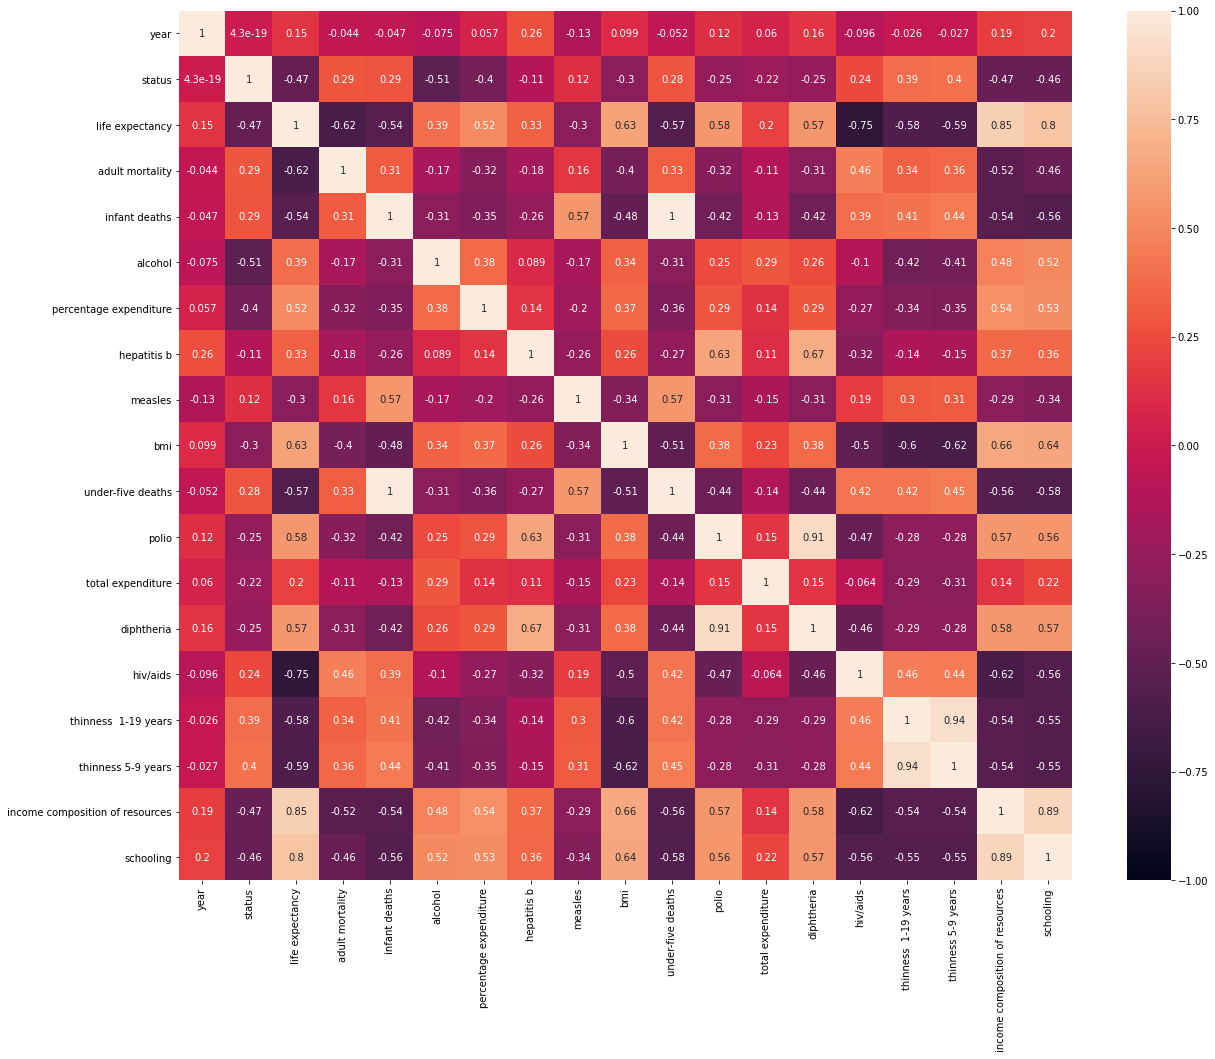

<IPython.core.display.Javascript object>

In [141]:
# Heatmap of correlation
plt.figure(figsize=(20, 16))
sns.heatmap(life_data.corr(), vmin=-1, vmax=1, annot=True)
plt.show()

In [57]:
# Top 5 features correlated to Life expectancy
life_corr = life_data.corr().abs()
life_corr = life_corr.replace(1, np.nan)
top_5_corr = life_corr.nlargest(5, "life expectancy")
top_5_corr_list = list(top_5_corr.index)
top_5_corr_list

['income composition of resources',
 'schooling',
 'hiv/aids',
 'adult mortality',
 'bmi']

<IPython.core.display.Javascript object>

##### Results
According to the f-scores from SelectKBest and our correlation matrix, we can conclude that the most useful features for predicting life expectancy are income composition of resources, adult mortality, thinness 5-9 years, schooling, thinness 1-19 years, hiv/aids, and bmi. These features can be used to train a model to predict life expectancy. This research can be improved by using more accurate data and data that does not have as many missing values.